In [1]:
#load packages 
import numpy as np
import pandas as pd
import scipy
import re
from PIL import Image
import glob
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from datetime import date
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
#grab file path names
image_paths = glob.glob("../data/movie-genre-from-its-poster/MoviePosters/*.jpg")
image_ids = []
for path in image_paths:
    start = path.rfind("/") +1
    end = len(path) - 4
    image_ids.append(path[start:end])

In [4]:
#sample image paths
image_path_sample = glob.glob("../data/movie-genre-from-its-poster/SampleMoviePosters/*.jpg")
image_ids_sample = []
for path in image_path_sample :
    start = path.rfind("/") +1
    end = len(path) - 4
    image_ids_sample.append(path[start:end])

In [5]:
df_movie = pd.read_csv("../data/movie-genre-from-its-poster/MovieGenre.csv", encoding = "ISO-8859-1")
df_imdb = pd.read_csv("../data/imdb.csv")

In [6]:
df_movie_sample = df_movie[df_movie["imdbId"].isin(image_ids_sample)]
df_movie_sample = df_movie_sample.drop_duplicates(subset=['imdbId'], keep="last")
target_sample = df_movie_sample['Genre']

In [7]:
titles = df_imdb['title'].to_list()

In [8]:
#too many garage movie poster limited it to well known movies
# and posters movies we have images for training
df_movie = df_movie[df_movie["imdbId"].isin(image_ids)]
df_movie = df_movie.drop_duplicates(subset=['imdbId'], keep="last")
df_movie["image_path"] = image_paths
df_movie = df_movie[df_movie["Title"].isin(titles)]


In [9]:
df_movie.shape

(2686, 7)

### Apply tuple in parallel

In [10]:
df_movie = df_movie.dropna()
image_paths = df_movie["image_path"].to_list()

In [11]:
df_movie.shape

(2685, 7)

In [12]:
df_movie["Genre"] = df_movie["Genre"].str.split("|")

In [13]:
y = df_movie["Genre"]

In [14]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
target_key = mlb.classes_

In [15]:
#define the data generator 

batch_size = 500
img_height = 268
img_width = 182
def data_generator(image_paths, y, batch_size = batch_size):
    num_samples = len(image_paths)
    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1

    while 1:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            image_paths_batch = image_paths[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            img_batch = np.array([img_to_array(
                    load_img(img, target_size=(img_height,img_width))
                    ) for img in image_paths_batch])
            
            
            img_batch = img_batch.astype('float32')/255.0
            
            yield img_batch, y_batch

In [16]:
#load sample images for testing
img_sample = np.array([img_to_array(
                    load_img(img, target_size=(img_height,img_width))
                    ) for img in image_path_sample[0:10]])
            
img_sample = img_sample.astype('float32')/255.0

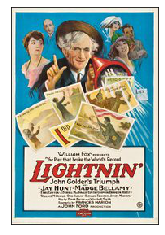

In [17]:
#check image are loading properly
plt.imshow(img_sample[1]);
plt.grid(True);
plt.xticks([]);
plt.yticks([]);

In [18]:
target_labels = target_key
total_classes = len(set(target_labels))
print("number of genre:", total_classes)

number of genre: 24


In [21]:
X_train_img, X_valid_img, y_train, y_valid = train_test_split(image_paths, y, 
                                                     random_state=42)

In [22]:
training_generator = data_generator(X_train_img, y_train)
validation_generator = data_generator(X_valid_img, y_valid)

steps_per_epoch = len(X_train_img) // batch_size
if len(X_train_img) % batch_size:
    steps_per_epoch += 1
    
validation_steps = len(X_valid_img) // batch_size
if len(X_valid_img) % batch_size:
    validation_steps += 1        

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
model.add(Activation('relu')) # this is just different syntax for specifying the activation function
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [24]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(total_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 266, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 266, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 133, 90, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 131, 88, 32)       9248      
_________________________________________________________________
activation_1 (Activation)    (None, 131, 88, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 42, 64)        1

In [25]:
epochs = 1
history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs) 

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 2 steps
5/5 [==============================] - 51s 10s/step - loss: 0.5607 - accuracy: 0.6887 - val_loss: 0.4492 - val_accuracy: 0.8416


In [148]:
today = date.today()
model.save('../model/large_movie_poster_'+str(today))

INFO:tensorflow:Assets written to: ../model/large_movie_poster_2020-05-27/assets


In [26]:
def poster_classification(img, target_key=target_key, model=model, ):
    proba = model.predict(img)[0]
    idxs = np.argsort(proba)[::-1][:2]
    print("Poster Prediction")
    for (i, j) in enumerate(idxs):
        label = "{}: {:.2f}%".format(target_key[j], proba[j] * 100)
    for (label, p) in zip(target_key, proba):
        if p >= .4:
            print("{}: {:.2f}%".format(label, p * 100))
            
    plt.imshow(img[0]);
    plt.grid(True);
    plt.xticks([]);
    plt.yticks([]);

In [45]:
img_test_predict = np.array([img_to_array(
                    load_img(image_paths[11], target_size=(img_height, img_width)))])
img_test_predict = img_test_predict.astype('float32')/255.0

Poster Prediction
Action: 54.84%
Adventure: 61.79%
Drama: 71.70%
Romance: 44.06%


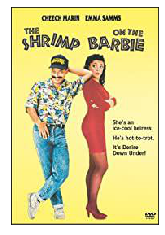

In [46]:
poster_classification(img_test_predict)